# microPAM utilities
## micoPAM console
The microPAM software includes a basic menu that can interacted with from the PC, using either a terminal program or the following Python and R scripts. 

### Python script

In [1]:
import serial
import serial.tools.list_ports

from datetime import datetime
def PC_time():
    date_time=datetime.now()
    print("Date and time is:", date_time)

def microPAM_showParameters():
    s=serial.tools.list_ports.comports(True)
    print(s[0].device)
    with serial.Serial(s[0].device) as ser:
        ser.reset_input_buffer
        ser.write(b'?p\r')
        for ii in range(5):
            print(ser.readline().decode('utf-8').rstrip())
    print()

def microPAM_syncTime():
    s=serial.tools.list_ports.comports(True)

    date_time=datetime.now()
    dd=date_time.strftime('!d%Y-%m-%d\r')
    tt=date_time.strftime('!t%H:%M:%S\r')

    with serial.Serial(s[0].device) as ser:
        ser.write(dd.encode())
        str=ser.readline().decode('utf-8').rstrip()
        print(str)

    with serial.Serial(s[0].device) as ser:
        ser.write(tt.encode())
        print(ser.readline().decode('utf-8').rstrip())

def microPAM_setParameter(token,value):
    s=serial.tools.list_ports.comports(True)
    with serial.Serial(s[0].device) as ser:
        data="!"+token+str(value)+"\r"
        ser.write(data.encode())
        print(ser.readline().decode('utf-8').rstrip())

def microPAM_readLines(value):
    s=serial.tools.list_ports.comports(True)
    with serial.Serial(s[0].device) as ser:
        for ii in range(value):
            print(ser.readline().decode('utf-8').rstrip())

def microPAM_command(value):
    s=serial.tools.list_ports.comports(True)
    with serial.Serial(s[0].device) as ser:
        ser.write(value.encode())


### Example of python based setup of microPAM

In [2]:
PC_time()
microPAM_connected = 1      # change to 1 if microPAM is connected to USB
if microPAM_connected:
    microPAM_showParameters()
    microPAM_syncTime()
#    microPAM_setParameter("f",44100)
#    microPAM_setParameter("s",12)
#    microPAM_setParameter("c",1)
    microPAM_showParameters()

Date and time is: 2024-11-23 14:32:27.426211
COM8


microPAM-V3 build Nov 23 2024 14:27:05
Now:
2024-11-23 14:32:28 0

2024-11-23
14:32:27
COM8


microPAM-V3 build Nov 23 2024 14:27:05
Now:
2024-11-23 14:32:28 0



### Example of python based monitoring of microPAM

In [34]:
if microPAM_connected:
    microPAM_command("m")   # switch on monitor
    microPAM_readLines(10)
    microPAM_command("m")   # switch off monitor

In [35]:
if microPAM_connected:
    microPAM_command("s")   # start archiving
    microPAM_readLines(5)
    microPAM_command("e")   # stop archiving

## microPAM GUI

In [ ]:
#%%writefile microPAM_GUI.py 
# uncomment prev line to save cell to file (is only in microPAM-utilities.ipynb file)
# micoPAM GUI
# use this cell to test and develop GUI
# to compile "pyinstaller microPAM_GUI.py --noconfirm"
# will generate "dist/micoPAM_GUI/microPAM_GUI.exe"
# and  "dist/micoPAM_GUI/_internal" with all required pyd/dll files
#
import os
import tkinter as tk
import time
from datetime import datetime
import serial
import serial.tools.list_ports

class Window(tk.Frame):

    def mEntry(self,txt,x,y,w,dx):
        label = tk.Label(text=txt,font=("Helvetica", 18))
        label.place(x=x-dx,y=y)
        edit = tk.Entry(text="", fg="Black", font=("Helvetica", 18),width=w)
        edit.place(x=x,y=y)
        return edit

    def mgetParam(self,ser,txt):
        ser.write(txt.encode())
        txt=ser.readline().decode('utf-8').rstrip()
        ip=txt.find("=")
        return txt[ip+2:]

    def mputEntry(self,edit,txt):
        edit.delete(0,tk.END)
        edit.insert(0,txt)

    def mUpdate(self,ser,edit,txt):
        ser.write(txt.encode())
        txt=ser.readline().decode('utf-8').rstrip()
        ip=txt.find("=")
        edit.delete(0,tk.END)
        edit.insert(0,txt[ip+2:])

    def mgetEntry(self,ser,str,edit):
        data=str+edit.get()+"\r"
        ser.write(data.encode())

    def ndays(self,d,m,y):
        def lpY(y): return (y%4==0) | ((y%100==0) & (y%400>0))
        dom=[31,28,31,30,31,30,31,31,30,31,30,31]
        #
        # number of days since 1-1-1970
        y1=y-1970
        days=y1*365
        for ii in range(y1): 
            if lpY(1970+ii): days +=1 
        #
        m -= 1
        for ii in range(m):
            days += dom[ii]
            if ii==1:
                if lpY(y): days += 1
        #
        d -= 1
        days += d
        return days, (days+4)%7 # 1-1-70 was thursday 1-1-24 was monday
    
    def nidays(self,days):
        def lpY(y): return (y%4==0) | ((y%100==0) & (y%400>0))
        dom=[31,28,31,30,31,30,31,31,30,31,30,31]
        #
        y1=0
        while days>0:
            if lpY(1970+y1): 
                days -=366
            else:
                days -= 365
            y1 +=1
        #
        if y1>0:
            y1 -= 1
        y1 += 1970
        if days<=0:
            if lpY(y1): 
                days += 366
            else:
                days += 365
        #
        days += 1
        m = 0
        while days >=0:
            if (m==1) & lpY(y1): days -=1
            days -= dom[m]
            m += 1
        days += dom[m-1]
        return (y1,m,days)

    def __init__(self, master=None):
        tk.Frame.__init__(self, master)        
        self.master = master

        # widget can take all window
        self.pack(fill=tk.BOTH, expand=1)

        label1 = tk.Label(text="PC:",font=("Helvetica", 18))
        label1.place(x=210,y=10)
        self.pcClocklabel = tk.Label(text="", fg="Red", font=("Helvetica", 18))
        self.pcClocklabel.place(x=270,y=10)
        self.update_clock()

        label2 = tk.Label(text="MCU:",font=("Helvetica", 18))
        label2.place(x=190,y=50)
        self.mcuClocklabel = tk.Label(text="", fg="Black", font=("Helvetica", 18))
        self.mcuClocklabel.place(x=270,y=50)

        xo=100
        yo=50
        self.sernum_edit = self.mEntry("SerNum:",xo,yo,6,100);

        xo=80
        yo=110
        dxo=230
        ii=0
        self.b_edit = self.mEntry("Author:", xo+ii*dxo,yo,10,80); ii+=1
        self.k_edit = self.mEntry("Project:",xo+ii*dxo-5,yo,10,85); ii+=1
        self.n_edit = self.mEntry("Location:",xo+ii*dxo+5,yo,10,100); ii+=1

        xo=120
        yo=170
        ii=0
        self.fsamp_edit = self.mEntry("fsamp:",xo,yo+ii*40,6,80); ii+=1
        self.proc_edit  = self.mEntry("proc:", xo,yo+ii*40,1,80); ii+=1
        self.shift_edit = self.mEntry("shift:",xo,yo+ii*40,2,80); ii+=1
        self.again_edit = self.mEntry("again:",xo,yo+ii*40,2,80); ii+=1

        xo=350
        yo=170
        ii=0
        self.t_acq_edit = self.mEntry("t_acq:",xo,yo+ii*40,5,80); ii+=1
        self.t_on_edit  = self.mEntry("t_on:", xo,yo+ii*40,5,80); ii+=1
        self.t_rep_edit = self.mEntry("t_rep:",xo,yo+ii*40,5,80); ii+=1
        ii=0
        xo += 160
        self.h_1_edit = self.mEntry("h_1:",xo,yo+ii*40,2,60); ii+=1
        self.h_2_edit = self.mEntry("h_2:",xo,yo+ii*40,2,60); ii+=1
        self.h_3_edit = self.mEntry("h_3:",xo,yo+ii*40,2,60); ii+=1
        self.h_4_edit = self.mEntry("h_4:",xo,yo+ii*40,2,60); ii+=1
        yo += 30
        self.d_start_edit = self.mEntry("d_start:",xo-320,yo+ii*40,3,90); 
        self.m_start_edit = self.mEntry("m_start:",xo-160,yo+ii*40,3,90); 
        self.y_start_edit = self.mEntry("y_start:",xo,yo+ii*40,5,90); ii+=1
        #
        self.d_on_edit    = self.mEntry("d_on:", xo,yo+ii*40,5,80); ii+=1
        self.d_rep_edit   = self.mEntry("d_rep:",xo,yo+ii*40,5,80); ii+=1

        # create buttons
        xm=600
        ym=170
        dym=60
        ii=0
        tk.Button(self, text="Exit", command=self.clickExitButton, font=("Helvetica", 18)).place(x=xm, y=10)
        tk.Button(self, text="Load", command=self.clickLoadButton, font=("Helvetica", 18)).place(x=xm, y=ym+ii*dym); ii+=1
        tk.Button(self, text="Sync", command=self.clickSyncButton, font=("Helvetica", 18)).place(x=xm, y=ym+ii*dym); ii+=1
        tk.Button(self, text="Save", command=self.clickSaveButton, font=("Helvetica", 18)).place(x=xm, y=ym+ii*dym); ii+=1
        self.storeButton = tk.Button(self, text="Store", command=self.clickStoreButton, font=("Helvetica", 18))
        self.storeButton.place(x=xm, y=ym+ii*dym)
    
        #
        date_time=datetime.now()
        self.mputEntry(self.d_start_edit,str(date_time.day))
        self.mputEntry(self.m_start_edit,str(date_time.month))
        self.mputEntry(self.y_start_edit,str(date_time.year))

        s=serial.tools.list_ports.comports(True)
        if len(s)>0:
            with serial.Serial(s[0].device) as ser:
                ser.reset_input_buffer()
                ser.reset_output_buffer()

    def clickExitButton(self):
        self.master.destroy() 

    def clickLoadButton(self):
        self.storeButton["state"]=tk.DISABLED
        s=serial.tools.list_ports.comports(True)
        if len(s)>0:
            with serial.Serial(s[0].device) as ser:
                ser.reset_input_buffer()
                # stop acquisition
                ser.write(b'e\r')
                txt=ser.readline().decode('utf-8').rstrip()
                # stop monitor
                ser.write(b':m0\r')
                txt=ser.readline().decode('utf-8').rstrip()
                ser.reset_input_buffer()
                #
                # load now data from device
                ser.write(b'?d\r')
                txt1=ser.readline().decode('utf-8').rstrip()
                ser.write(b'?t\r')
                txt2=ser.readline().decode('utf-8').rstrip()
                ip1=txt1.find("=")
                ip2=txt2.find("=")
                self.mcuClocklabel.configure(text=txt1[ip1+2:]+txt2[ip2+1:])
                #
                self.mUpdate(ser,self.b_edit,"?b")
                self.mUpdate(ser,self.k_edit,"?k")
                self.mUpdate(ser,self.n_edit,"?n")
                #
                self.mUpdate(ser,self.sernum_edit,"?h")
                #
                self.mUpdate(ser,self.t_acq_edit,"?a")
                self.mUpdate(ser,self.t_on_edit, "?o")
                self.mUpdate(ser,self.t_rep_edit,"?r")
                #
                self.mUpdate(ser,self.h_1_edit,"?1")
                self.mUpdate(ser,self.h_2_edit,"?2")
                self.mUpdate(ser,self.h_3_edit,"?3")
                self.mUpdate(ser,self.h_4_edit,"?4")
                #
                self.mUpdate(ser,self.d_on_edit,"?5")
                self.mUpdate(ser,self.d_rep_edit,"?6")
                #
                self.mUpdate(ser,self.fsamp_edit,"?f")
                self.mUpdate(ser,self.proc_edit, "?c")
                self.mUpdate(ser,self.shift_edit,"?s")
                self.mUpdate(ser,self.again_edit,"?g")
                #
                days=int(self.mgetParam(ser,"?0"))
                year,month,day=self.nidays(days+20000)
                self.mputEntry(self.d_start_edit,str(day))
                self.mputEntry(self.m_start_edit,str(month))
                self.mputEntry(self.y_start_edit,str(year))
        else:
            #for items in os.listdir():  print(items)
            print("current directory: ",os.getcwd())
            with open("config.txt","r") as f:
                for line in f:
                    ip0=line.find("=")
                    ip1=line.find(";")
                    match line[0]:
                        case 'b': self.mputEntry(self.b_edit,line[ip0+1:ip1])
                        case 'k': self.mputEntry(self.k_edit,line[ip0+1:ip1])
                        case 'n': self.mputEntry(self.n_edit,line[ip0+1:ip1])

                        case 'a': self.mputEntry(self.t_acq_edit,line[ip0+1:ip1])
                        case 'o': self.mputEntry(self.t_on_edit, line[ip0+1:ip1])
                        case 'r': self.mputEntry(self.t_rep_edit,line[ip0+1:ip1])
                        #
                        case '1': self.mputEntry(self.h_1_edit,line[ip0+1:ip1])
                        case '2': self.mputEntry(self.h_2_edit,line[ip0+1:ip1])
                        case '3': self.mputEntry(self.h_3_edit,line[ip0+1:ip1])
                        case '4': self.mputEntry(self.h_4_edit,line[ip0+1:ip1])
                        #
                        case '5': self.mputEntry(self.d_on_edit, line[ip0+1:ip1])
                        case '6': self.mputEntry(self.d_rep_edit,line[ip0+1:ip1])
                        #
                        case 'f': self.mputEntry(self.fsamp_edit,line[ip0+1:ip1])
                        case 'c': self.mputEntry(self.proc_edit, line[ip0+1:ip1])
                        case 's': self.mputEntry(self.shift_edit,line[ip0+1:ip1])
                        case 'g': self.mputEntry(self.again_edit,line[ip0+1:ip1])
                        #
                        case '0':
                            days=int(line[ip0+1:ip1])
                            year,month,day=self.nidays(days+20000)
                            self.mputEntry(self.d_start_edit,str(day))
                            self.mputEntry(self.m_start_edit,str(month))
                            self.mputEntry(self.y_start_edit,str(year))


    def clickSaveButton(self):
        dx=self.d_start_edit.get()
        mx=self.m_start_edit.get()
        yx=self.y_start_edit.get()
        days,dow=self.ndays(int(dx),int(mx),int(yx))
        #
        s=serial.tools.list_ports.comports(True)
        if len(s)>0:
            with serial.Serial(s[0].device) as ser:
                ser.read_all()
                self.mgetEntry(ser,'!b',self.b_edit)
                self.mgetEntry(ser,'!k',self.k_edit)
                self.mgetEntry(ser,'!n',self.n_edit)
                #
                self.mgetEntry(ser,'!a',self.t_acq_edit)
                self.mgetEntry(ser,'!o',self.t_on_edit)
                self.mgetEntry(ser,'!r',self.t_rep_edit)
                #
                self.mgetEntry(ser,'!1',self.h_1_edit)
                self.mgetEntry(ser,'!2',self.h_2_edit)
                self.mgetEntry(ser,'!3',self.h_3_edit)
                self.mgetEntry(ser,'!4',self.h_4_edit)
                #
                self.mgetEntry(ser,'!5',self.d_on_edit)
                self.mgetEntry(ser,'!6',self.d_rep_edit)
                #
                self.mgetEntry(ser,'!f',self.fsamp_edit)
                self.mgetEntry(ser,'!c',self.proc_edit)
                self.mgetEntry(ser,'!s',self.shift_edit)
                self.mgetEntry(ser,'!g',self.again_edit)
                #
                data="!0"+str(days-20000)+"\r"
                print('put', data)
                ser.write(data.encode())
                #
                ser.read_all()
        with open("config.txt","w") as f:
            f.write("b="+self.b_edit.get()+"; author\n")
            f.write("k="+self.k_edit.get()+"; project\n")
            f.write("n="+self.n_edit.get()+"; site\n")
            #
            f.write("a="+self.t_acq_edit.get()+"; t_acq\n")
            f.write("o="+self.t_on_edit.get()+"; t_on\n")
            f.write("r="+self.t_rep_edit.get()+"; t_rep\n")
            #
            f.write("1="+self.h_1_edit.get()+"; h_1\n")
            f.write("2="+self.h_2_edit.get()+"; h_2\n")
            f.write("3="+self.h_3_edit.get()+"; h_3\n")
            f.write("4="+self.h_4_edit.get()+"; h_4\n")
            #
            f.write("5="+self.d_on_edit.get()+"; d_on\n")
            f.write("6="+self.d_rep_edit.get()+"; d_rep\n")
            #
            f.write("f="+self.fsamp_edit.get()+"; fsamp\n")
            f.write("c="+self.proc_edit.get()+"; proc\n")
            f.write("s="+self.shift_edit.get()+"; shift\n")
            f.write("g="+self.again_edit.get()+"; again\n")
            #
            f.write("0="+str(days-20000)+"; d_0\n")

        print("current directory: ",os.getcwd())
        #for items in os.listdir():  print(items)
        self.storeButton["state"]=tk.NORMAL

    def clickStoreButton(self):
        s=serial.tools.list_ports.comports(True)
        if len(s)>0:
            with serial.Serial(s[0].device) as ser:
                ser.read_all()
                ser.write("!w1\r".encode())
                time.sleep(0.1)
                txt=ser.readline().decode('utf-8').rstrip()
                #
                ser.write(":w".encode())
                time.sleep(0.1)
                txt=ser.readline().decode('utf-8').rstrip()
                txt=ser.readline().decode('utf-8').rstrip()
                print(txt)

    def clickSyncButton(self):
        date_time=datetime.now()
        dd=date_time.strftime("!d%Y-%m-%d\r")
        tt=date_time.strftime("!t%H:%M:%S\r")

        s=serial.tools.list_ports.comports(True)
        if len(s)>0:
            with serial.Serial(s[0].device) as ser:
                ser.write(tt.encode())
            with serial.Serial(s[0].device) as ser:
                ser.write(dd.encode())
            with serial.Serial(s[0].device) as ser:
                ser.write(b':c')

    def update_clock(self):
        now = time.strftime("%Y-%m-%d %H:%M:%S")
        self.pcClocklabel.configure(text=now)
        self.after(1000, self.update_clock)

root = tk.Tk()
app = Window(root)
root.wm_title("MicroPAM V3 (WMXZ)")
root.geometry("700x500")

root.after(1000, app.update_clock)
root.mainloop() 

Overwriting microPAM_GUI.py


## R scripts
The following functions allow the interaction with the microPAM using R 

```
library('serial')

listParameters <- function()
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='cr')
	if(isOpen(com)==FALSE) open(com)

	write.serialConnection(com,"?p\r\n")
	flush(com)
	Sys.sleep(0.1)
	ret<-read.serialConnection(com)
	close(com)
	cat(c(ret,"\n"))
}

syncTime <- function()
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='cr')
	if(isOpen(com)==FALSE) open(com)

	now=Sys.time()

	dd=format(now,"!d%Y-%m-%d\r\n")
	write.serialConnection(com,dd)
	flush(com)
	Sys.sleep(0.1)

	ret<-read.serialConnection(com)
	cat(ret)

	tt=format(now,"!t%H-%M-%S\r\n")
	write.serialConnection(com,tt)
	flush(com)
	Sys.sleep(0.1)

	ret<-read.serialConnection(com)

	cat(c(ret,"\n"))
	close(com)
}

setParameter <- function(token,value)
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='cr')
	if(isOpen(com)==FALSE) open(com)

	uu=sprintf("!%s%d\r\n",token,value)
	write.serialConnection(com,uu)
	flush(com)
	Sys.sleep(0.1)

	ret<-read.serialConnection(com)
	cat(c(ret,"\n"))
	close(com)
}

doCommand <- function(token)
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='cr')
	if(isOpen(com)==FALSE) open(com)

	uu=sprintf("%s\r\n",token)
	write.serialConnection(com,uu)
	flush(com)
	close(com)
}

monitor <- function(num)
{
	ser <- listPorts()
	com <- serialConnection(name="microPAM",port=ser,
			buffering='line',
			translation='lf')
	if(isOpen(com)==FALSE) open(com)

	ret<-read.serialConnection(com)
	for (ii in 1:num)
	{ Sys.sleep(1)
  	  ret<-read.serialConnection(com)
	  cat(c(ret,'\n'))
	}
	close(com)
}
```

## basic audio test (wav file generation) script

In [37]:
import numpy as np
import wavio
rate = 22050             # samples per second
T = 3                    # sample duration (seconds)
f = 440.0                # sound frequency (Hz)
t = np.linspace(0, T, T*rate, endpoint=False)
sig = np.sin(2 * np.pi * f * t)
wavio.write("sine24.wav", sig, rate, sampwidth=3)   # 24 bit data (sampwidth=3)

## Elliptical filters
Low-pass filter with elliptical (Cauer) filter for very low (< 1kHz) corner frequencies
- first decimate data to about 2400 Hz
- estimate biquad filter coefficients with python script
- apply 3 biquad filter

[[ 0.00454991  0.00480905  0.00454991  1.         -1.54273107  0.64191613]
 [ 1.         -0.63758644  1.          1.         -1.43156463  0.80165859]
 [ 1.         -1.02047284  1.          1.         -1.37624928  0.94360981]]


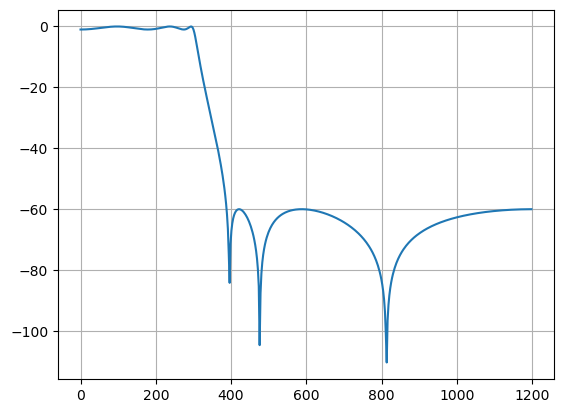

In [38]:
import numpy as np
from scipy.signal import ellip, sosfreqz
import scipy.signal as sig
import matplotlib.pyplot as plt

Fs = 2400

x = sig.ellip(6, 1, 60, [300 / (Fs / 2)], output='sos')
print(x)
freqs, resps = sig.sosfreqz(x, fs = Fs)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid()

ax.plot(freqs, 20 * np.log10(np.abs(resps)))

plt.show()


# Get file information
Run next cell and open microPAM data files (wav or bin) to print out meta data

In [9]:
#%%writefile microPAM_Info.py 
import numpy as np

from tkinter import filedialog

def headerDecode(xx):
        #print(xx[0].tobytes().decode())    # magic
        timestamp=xx[1:5].tobytes().decode() #timestamp
        sernum=xx[5:8].tobytes()[1:9].decode()   #sernum
        tt=xx[8]   #tt
        b_string=xx[9:19].tobytes().decode()    #owner
        k_string=xx[19:29].tobytes().decode()   #experiment
        n_string=xx[29:39].tobytes().decode()   #location
        pp=np.frombuffer(xx[39:47],dtype='int16')
        #print(xx[58].tobytes().decode())    #end

        print('author    =',b_string)
        print('project   =',k_string)
        print('location  =',n_string)
        print('sernum    =',sernum)
        print('timestamp =',timestamp)
        print('millis    =',tt)
        print('parameters=',pp)
        print('proc  =',pp[4])
        print('shift =',pp[5])
        print('again =',pp[13])
        print('dgain =',pp[14])
        print('t_acq =',pp[1])
        print('t_on  =',pp[2])
        print('t_rep =',pp[3])
        print('d_on  =',pp[10])
        print('d_rep =',pp[11])
        print('d_0   =',pp[15])
        print()

file_names = filedialog.askopenfilenames(initialdir="./")
#
wav_files = [name for name in file_names if name.endswith('.wav')]
bin_files = [name for name in file_names if name.endswith('.bin')]
if len(bin_files)>0:
    for name in bin_files:
        xx = np.fromfile(name, dtype='uint32',count=128)
        print(xx[0].tobytes().decode())    # WMXZ
        # bin header
        vers=xx[5]
        sernum=xx[6]
        fs = xx[7] # sampling frequency
        cp = xx[12] # data compress mode
        sh = xx[13] # shift in bits
        timestamp=(xx[1:5].tobytes()).decode()
        print('timestanp=',timestamp)
        print('vers     =',vers)
        print('sernum   =',hex(sernum))
        print('proc     =',cp)
        print('fs       =',fs)
        print('shift    =',sh)
        if(vers>=30):
            headerDecode(xx[20:68])

if len(wav_files)>0:
    for name in wav_files:
        xx = np.fromfile(name, dtype='uint32',count=128)
        # wav header
        print(xx[0].tobytes().decode())    # RIFF
        nch=xx[5]>>16
        fs=xx[6]
        nalign=xx[8]&0xffff
        nbits=xx[8]>>16
        # micoPAM info
        if xx[9].tobytes().decode()=='info':
            headerDecode(xx[11:59])
        #print(xx[126].tobytes().decode())    # data
        nbytes=xx[127]
        nsecs=nbytes/(nbits/8)/nch/fs

        print('nbits     =',nbits)
        print('nch       =',nch)
        print('fs        =',fs)
        print('nbytes    =',nbytes)
        print('nsecs     =',nsecs)
#

WMXZ
timestanp= 20230402_082400 
vers     = 12
sernum   = 0x1382ae
proc     = 1
fs       = 48000
shift    = 12


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog

from microPAM_utils import loadAcoustics

file_names = filedialog.askopenfilenames(initialdir="./")


48000 1 12 30 4678223 20241219_203400 


c:\Users\zimme\jupyter\microPAM\microPAM_utils.py:209: RuntimeWarning: overflow encountered in scalar subtract
  ndx=nd1-nch


(458240, 1) (483712,)


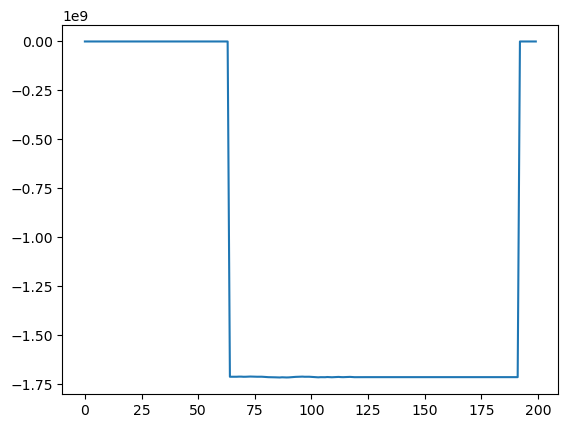

In [ ]:
for fileName in file_names:
    dat,ta,to,td1,td2,fs,sh,SerNum=loadAcoustics(fileName)

print(dat.shape,ta.shape)
plt.plot(dat[84800:85000])
plt.show()

In [46]:
import numpy as np

a=np.array([1,2,-3,4,5,6],dtype='int')
b=(np.random.rand(6)*2**32).astype('int')
c=a^b[0]
print(c)
d=c^a
print(d)
e=c^b[0]
print(e)
f=np.frombuffer(bytearray(b"dies ist ein test   1234"),dtype='int32')
g=a^f
print(g)
print(g^f)

[ 3490754064  3490754067 -3490754068  3490754069  3490754068  3490754071]
[3490754065 3490754065 3490754065 3490754065 3490754065 3490754065]
[ 1  2 -3  4  5  6]
[ 1936025957  1953720610 -1852400931  1936028708   538976369   875770423]
[ 1  2 -3  4  5  6]
